- remove chl signal from XMIS based on STRATOGEM data
- apply fit to FRP data and calculate relationship of turbidity to residuals
- apply that fit to STRATOGEM data and inspect characteristics

In [1]:
from sqlalchemy import create_engine, Column, String, Integer, Boolean, MetaData, Table, case, between, ForeignKey
from sqlalchemy.orm import mapper, create_session, relationship
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.ext.automap import automap_base
import sqlalchemy.types as types
from sqlalchemy.sql import select, and_, or_, not_, func

import numpy as np
import pandas as pd
import gsw
import matplotlib.pyplot as plt
from salishsea_tools import loadDataFRP as cf

import os
from scipy import signal as ssig
from scipy import stats as spst
import scipy.optimize as scopt

import PARfuns as dpro
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
%matplotlib inline

matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'legend.numpoints': 1})

## First step: for STRATOGEM data, convert transmissivity to beam transmission, then remove component proportional to chlorophyll to get corrected beam transmission

load Stratogem data

In [2]:
basepath='/ocean/eolson/MEOPAR/obs/'
basedir=basepath + 'STRATOGEM/'
dbname='STRATOGEM'

Base = automap_base()
engine = create_engine('sqlite:///' + basedir + dbname + '.sqlite', echo = False)
# reflect the tables in salish.sqlite:
Base.prepare(engine, reflect=True)
# mapped classes have been created

CombStaTBL=Base.classes.CombStationTBL
CombProfTBL=Base.classes.CombProfTBL
CTDStationTBL=Base.classes.CTDStationTBL
CTDProfTBL=Base.classes.CTDProfTBL
session = create_session(bind = engine, autocommit = False, autoflush = True)

In [3]:
# transmissivity data:
qXF=session.query(CTDProfTBL.CTDStationTBLID.label('StaID'),
                     CTDProfTBL.prSM,
                     CTDProfTBL.convertedDepth.label('Depth'),
                     CTDProfTBL.xmiss,
                     CTDProfTBL.wetStar).filter(and_(
                    CTDProfTBL.wetStar>0,
                    CTDProfTBL.prSM>0,
                    CTDProfTBL.xmiss>0,
                    CTDProfTBL.xmiss<100,
                    CTDProfTBL.CTDStationTBLID!=321
    )).group_by(CTDProfTBL.CTDStationTBLID,CTDProfTBL.prSM
                                            ).order_by(CTDProfTBL.CTDStationTBLID,CTDProfTBL.prSM)
                     
qXFsub=qXF.subquery()
dfXF=pd.DataFrame(qXF.all())
dfXF['cX']=cf.cXfromX(dfXF['xmiss']) 
#def cXfromX(X): .25 is dz
#    X=np.array(X)
#    X[np.isnan(X)]=-5
#    Y=np.nan*X
#    iii=(X>0)&(X<100)
#    Y[iii]=-np.log(X[iii]/100.0)/.25
#    return Y

[0.05298568 0.2503553 ]
[0.04033208 0.43784622]


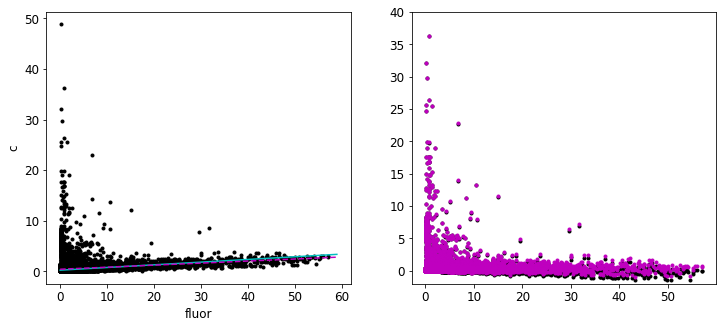

In [4]:
# remove component of cX that is due to F
# m uses all data, but m2, which is used going forward (magenta), first eliminates 
# high cX and low chl values that seem to add noise and skew data, 
# getting rid of negative slope in corrected cX at high F
A=np.vstack([dfXF['wetStar'],np.ones(len(dfXF['wetStar']))]).T
Y=dfXF['cX']
m=np.linalg.lstsq(A,Y,rcond=None)[0]
print(m)
ii=(dfXF['cX']<5.0)&(dfXF['wetStar']>10)
A2=np.vstack([dfXF.loc[ii]['wetStar'],np.ones(len(dfXF.loc[ii]['wetStar']))]).T
Y2=dfXF.loc[ii]['cX']
m2=np.linalg.lstsq(A2,Y2,rcond=None)[0]

fig,ax=plt.subplots(1,2,figsize=(12,5))
ax[0].plot(dfXF['wetStar'],dfXF['cX'],'k.')
ax[0].plot(np.arange(0,60),m[0]*np.arange(0,60)+m[1],'c-')
ax[0].plot(np.arange(0,60),m2[0]*np.arange(0,60)+m2[1],'m--')
ax[0].set_xlabel('fluor')
ax[0].set_ylabel('c')
#ax[0].set_ylim(-1,5)
#ax[0].set_xlim(-1,5)

ax[1].plot(dfXF['wetStar'],dfXF['cX']-m[0]*dfXF['wetStar'],'k.')
ax[1].plot(dfXF['wetStar'],dfXF['cX']-m2[0]*dfXF['wetStar'],'m.')
ax[1].set_ylim(-2,40)
print(m2)
ctochl=m2[0]

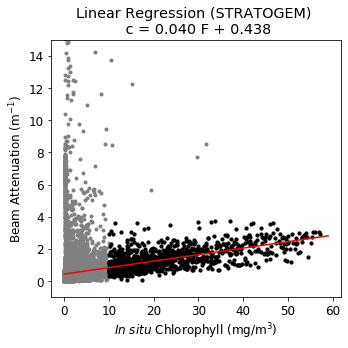

In [5]:
# show in figure
A=np.vstack([dfXF['wetStar'],np.ones(len(dfXF['wetStar']))]).T
ii=(dfXF['cX']<5.0)&(dfXF['wetStar']>10)
A2=np.vstack([dfXF.loc[ii]['wetStar'],np.ones(len(dfXF.loc[ii]['wetStar']))]).T
Y2=dfXF.loc[ii]['cX']
m2=np.linalg.lstsq(A2,Y2,rcond=None)[0]

fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.plot(dfXF['wetStar'],dfXF['cX'],'.',color='gray')
ax.plot(dfXF.loc[ii]['wetStar'],dfXF.loc[ii]['cX'],'k.')
ax.plot(np.arange(0,60),m2[0]*np.arange(0,60)+m2[1],'r-')
ax.set_xlabel('$\it{In}$ $\it{situ}$ Chlorophyll (mg/m$^3$)')
ax.set_ylabel('Beam Attenuation (m$^{-1}$)')
ax.set_ylim(-1,15)
ax.set_title('Linear Regression (STRATOGEM) \n c = 0.040 F + 0.438')
#ax[0].set_xlim(-1,5) 
plt.tight_layout()
box = ax.get_position()
#fig.savefig('/home/eolson/pyCode/notebooks/PARModel/doc/CvsF1.png',dpi=400,transparent=True)

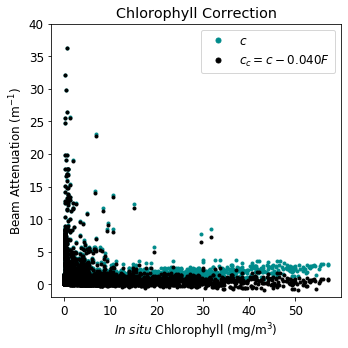

In [6]:
# another figure, showing cX after correction:
fig,ax=plt.subplots(1,1,figsize=(5,5))
orig,=ax.plot(dfXF['wetStar'],dfXF['cX'],'.',color='darkcyan',label='original')
corrc,=ax.plot(dfXF['wetStar'],dfXF['cX']-m2[0]*dfXF['wetStar'],'k.',label='Chl-corrected')
ax.set_ylim(-2,40)
ax.set_xlabel('$\it{In}$ $\it{situ}$ Chlorophyll (mg/m$^3$)')
ax.set_ylabel('Beam Attenuation (m$^{-1}$)')
ax.set_title('Chlorophyll Correction')
opatch=mlines.Line2D([], [], color='darkcyan', marker='.',linewidth=0,
                          markersize=10, label='$c$')
cpatch = mlines.Line2D([], [], color='k', marker='.',linewidth=0,
                          markersize=10, label='$c_c=c - 0.040 F$')
ax.legend(handles=[opatch, cpatch],loc=1)
plt.tight_layout()
#fig.savefig('/home/eolson/pyCode/notebooks/PARModel/doc/CvsF2.png',dpi=400,transparent=True)

# now load FRP data and use the same STRATOGEM correction factor on the FRP beam transmission

In [7]:
df0, zCasts=cf.loadDataFRP(exp='all',sel='wide')

In [8]:
# first make flattened dataframe
dfulist=dict()
dfdlist=dict()
clist=np.sort([ii for ii in zCasts.keys()])
ii=0
for nn in clist:
    if nn!=14.1:
        ii+=1
        dfulist[nn]=zCasts[nn].uCast.copy()
        dfulist[nn]['isup']=1
        dfulist[nn]['sta']=nn
        dfulist[nn]['castid']=ii
    if nn!=14.2:
        ii+=1
        dfdlist[nn]=zCasts[nn].dCast.copy()
        dfdlist[nn]['isup']=0
        dfdlist[nn]['sta']=nn
        dfdlist[nn]['castid']=ii

dfall=dfulist[clist[0]].copy()
dfall=dfall.append(dfdlist[clist[0]], ignore_index=True)

for ii in range(1,len(clist)):
    nn=clist[ii]
    if nn!=14.1: dfall=dfall.append(dfulist[nn], ignore_index=True)
    if nn!=14.2: dfall=dfall.append(dfdlist[nn], ignore_index=True)
dfall['cx']=cf.cXfromX(dfall['xmiss'])
dfall['NTU']=dfall['turb'] # new version of code has already done conversion
cI=dfall['cx']-ctochl*dfall['wetStar']

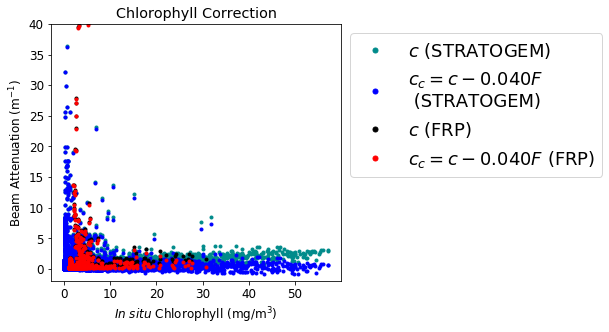

In [9]:
# plot all corrections
fig,ax=plt.subplots(1,1,figsize=(10,5))
orig,=ax.plot(dfXF['wetStar'],dfXF['cX'],'.',color='darkcyan',label='original')
corrc,=ax.plot(dfXF['wetStar'],dfXF['cX']-m2[0]*dfXF['wetStar'],'b.',label='Chl-corrected')
plt.plot(dfall['wetStar'],dfall['cx'],'k.')
plt.plot(dfall['wetStar'],cI,'r.')
ax.set_ylim(-2,40)
ax.set_xlabel('$\it{In}$ $\it{situ}$ Chlorophyll (mg/m$^3$)')
ax.set_ylabel('Beam Attenuation (m$^{-1}$)')
ax.set_title('Chlorophyll Correction')
opatch=mlines.Line2D([], [], color='darkcyan', marker='.',linewidth=0,
                          markersize=10, label='$c$ (STRATOGEM)')
cpatch = mlines.Line2D([], [], color='b', marker='.',linewidth=0,
                          markersize=10, label='$c_c=c - 0.040 F$\n (STRATOGEM)')
opatch2=mlines.Line2D([], [], color='k', marker='.',linewidth=0,
                          markersize=10, label='$c$ (FRP)')
cpatch2 = mlines.Line2D([], [], color='r', marker='.',linewidth=0,
                          markersize=10, label='$c_c=c - 0.040 F$ (FRP)')

ax.set_position([box.x0, box.y0, box.width * 0.5, box.height])

# Put a legend to the right of the current axis
ax.legend(handles=[opatch, cpatch,opatch2,cpatch2],fontsize=18,
          loc='center left', bbox_to_anchor=(1, 0.685))
#plt.tight_layout()
#fig.savefig('/home/eolson/pyCode/notebooks/PARModel/doc/CvsF3.png',dpi=400,transparent=True)

### plot NTU vs absolute salinity; we expect less plume sediment and more contribution by chlorophyll at higher salinity

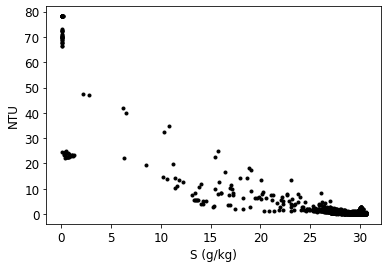

In [10]:
plt.plot(dfall['gsw_srA0'],dfall['NTU'],'k.');
plt.xlabel('S (g/kg)');
plt.ylabel('NTU');

In [11]:
## now look for relationship between chlorophyll, beam attenuation, and turbidity in FRP data

In [12]:
# fit turb = a * cI + b * chl + c
ii=(~np.isnan(cI))&(~np.isnan(dfall['NTU']))
A=np.vstack([cI[ii],dfall.loc[ii]['wetStar'],np.ones(len(cI[ii]))]).T
b=dfall.loc[ii]['NTU']
m=np.linalg.lstsq(A,b,rcond=None)[0]
print(m)
turbfit=m

[ 1.63088835  0.02874517 -0.08360998]


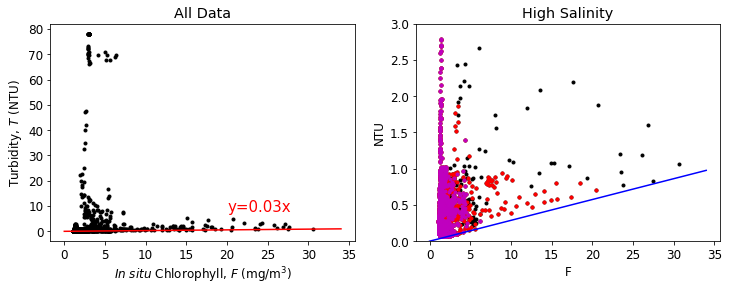

In [13]:
fig,ax=plt.subplots(1,2,figsize=(12,4))
ax[0].plot(dfall['wetStar'],dfall['NTU'],'k.')
ax[0].plot(np.arange(0,35),turbfit[1]*np.arange(0,35),'r-')
ax[0].text(20, 8, r'y={:1.2f}x'.format(turbfit[1]), fontsize=15,color='r')
ax[0].set_xlabel('$\it{In}$ $\it{situ}$ Chlorophyll, $F$ (mg/m$^3$)')
ax[0].set_ylabel('Turbidity, $T$ (NTU)')
ax[0].set_title('All Data')
#ax[0].set_position([.15,.2,.65,.65])
#fig.savefig('/home/eolson/pyCode/notebooks/PARModel/doc/TvsF.png',dpi=400,transparent=True)

ii=dfall['gsw_srA0']>27
ax[1].plot(dfall.loc[ii]['wetStar'],dfall.loc[ii]['NTU'],'k.')
ii=dfall['gsw_srA0']>28
ax[1].plot(dfall.loc[ii]['wetStar'],dfall.loc[ii]['NTU'],'r.')
ii=dfall['gsw_srA0']>29
ax[1].plot(dfall.loc[ii]['wetStar'],dfall.loc[ii]['NTU'],'m.')
ax[1].set_ylim(0,3)
ax[1].set_xlabel('F')
ax[1].set_ylabel('NTU')
ax[1].set_title('High Salinity')
ax[1].plot(np.arange(0,35),turbfit[1]*np.arange(0,35),'b-')

slope: 1.6308883467023396 intercept: -0.08360997736325793
r_value: 0.9940566341001059 p_value: 0.0 std_err: 0.0032912087608919184
r2: 0.9881485917984318


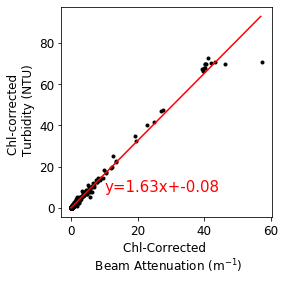

In [14]:
fig,ax=plt.subplots(1,1,figsize=(4.5,4.5))
ax.plot(cI,dfall['NTU'],'k.')
ax.plot(np.arange(0,np.max(cI)),turbfit[0]*np.arange(0,np.max(cI)),'r-')
ax.text(10, 8, r'y={:1.2f}x+{:1.2f}'.format(turbfit[0],turbfit[2]), fontsize=15,color='r')
ax.set_xlabel('Chl-Corrected \n Beam Attenuation (m$^{-1}$)') #, $c_I$ 
ax.set_ylabel('Chl-corrected \n Turbidity (NTU)') #, $T$
ax.set_position([.25,.25,.65,.65])
#fig.savefig('/home/eolson/pyCode/notebooks/PARModel/doc/TvsCI.png',dpi=400,transparent=True)

ii=(~np.isnan(cI))&(~np.isnan(dfall['NTU']))
slope, intercept, r_value, p_value, std_err = spst.linregress(cI[ii],
                                dfall.loc[ii]['NTU']-turbfit[1]*dfall.loc[ii]['wetStar'])
print('slope:',slope,'intercept:',intercept)
print('r_value:', r_value, 'p_value:', p_value, 'std_err:', std_err)
print('r2:', r_value*r_value)

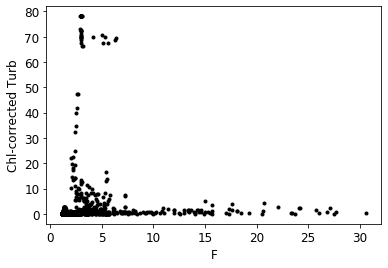

In [15]:
frturbI=dfall['NTU']-turbfit[1]*dfall['wetStar']
plt.plot(dfall['wetStar'],frturbI,'k.')
plt.xlabel('F')
plt.ylabel('Chl-corrected Turb');

Text(0, 0.5, 'T_est')

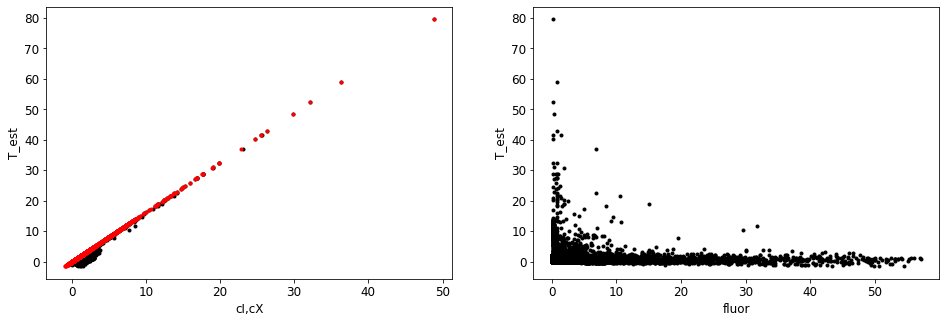

In [16]:
# now use relationships to estimate turbidity from beam attenuation in STRATOGEM data;
# check if used both correction factors or one???
dfXF['cI']=dfXF['cX']-ctochl*dfXF['wetStar']
dfXF['Test']=turbfit[0]*dfXF['cI']+turbfit[2]
fig,ax=plt.subplots(1,2,figsize=(16,5))
ax[0].plot(dfXF['cX'],dfXF['Test'],'k.')
ax[0].plot(dfXF['cI'],dfXF['Test'],'r.')
ax[0].set_xlabel('cI,cX')
ax[0].set_ylabel('T_est')
ax[1].plot(dfXF['wetStar'],dfXF['Test'],'k.')
ax[1].set_xlabel('fluor')
ax[1].set_ylabel('T_est')
#ax[0].set_xlim(0,10)
#ax[0].set_ylim(0,10)

min T est: -1.5512524770329508  note: T est function has been changed to return zero if the predicted value is less than zero
max T est: 79.53231916896252


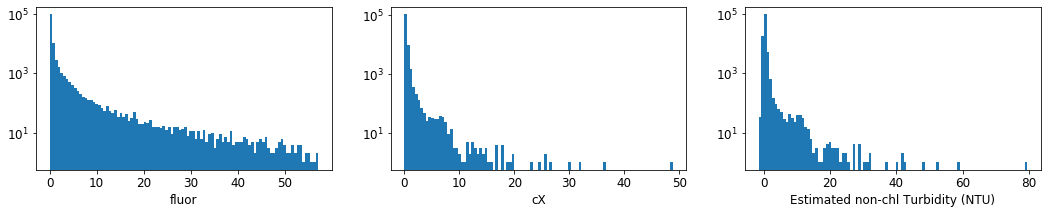

In [17]:
fig,ax=plt.subplots(1,3,figsize=(18,3))
ax[0].hist(dfXF['wetStar'],100)
ax[0].set_xlabel('fluor')
ax[0].set_yscale('log')
ax[1].hist(dfXF['cX'],100)
ax[1].set_xlabel('cX')
ax[1].set_yscale('log')
ax[2].hist(dfXF['Test'],100)
ax[2].set_xlabel('Estimated non-chl Turbidity (NTU)')
ax[2].set_yscale('log')
print('min T est:', np.min(dfXF['Test']), ' note: T est function has been changed to return zero if the predicted value is less than zero')
print('max T est:', np.max(dfXF['Test']))